# Ptychography Tutorial 02 (Modified by Wendy Wan)

This is the second tutorial notebook in the iterative ptychography series.  
In this tutorial notebook we will cover:
- The origin of the pathological gridding artifact
- Various reconstruction parameter remedies

### Downloads
This tutorial uses the following datasets:
- [ptycho_ducky_simulation_03.h5](https://drive.google.com/file/d/1rCWIokqDGINpex_zYz4ryiiEkfuh1xTI/view?usp=drive_link)
- [ptycho_ducky_vacuum-probe_03.h5](https://drive.google.com/file/d/1aiZbsXU1dUf4RIHZDLUbWsGZlZZAaClM/view?usp=drive_link)

### Acknowledgements

This tutorial was created by the py4DSTEM `phase_contrast` team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

Last updated 2024 May 6

## Pathological Gridding Artifact

In the previous tutorial, we saw a pronnounced gridding artifact in our single-slice reconstruction of ducky.  
Let's quickly reproduce that by importing the dataset and running a few ptychographic iterations.

In [1]:
import numpy as np
import py4DSTEM
import matplotlib.pyplot as plt

print(py4DSTEM.__version__)

cupyx.jit.rawkernel is experimental. The interface can change in the future.


0.14.18


In [2]:
file_path = '../data/'
file_data_01 = file_path + 'ptycho_ducky_simulation_03.h5'
file_probe_01 = file_path + 'ptycho_ducky_vacuum-probe_03.h5'

dataset_01 = py4DSTEM.read(file_data_01)
probe_01 = py4DSTEM.read(file_probe_01)
dataset_01.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:     0.025
             R_pixel_size:     4.0
             Q_pixel_units:    A^-1
             R_pixel_units:    A
             QR_flip:          False
             _root_treepath:   
)

Best fit rotation = -15 degrees.
Normalizing amplitudes: 100%|██████████| 1681/1681 [00:05<00:00, 323.43probe position/s]
Performing 64 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step_size: 0.5, in batches of max 512 measurements.
Reconstructing object and probe: 100%|██████████| 64/64 [00:12<00:00,  5.18 iter/s]


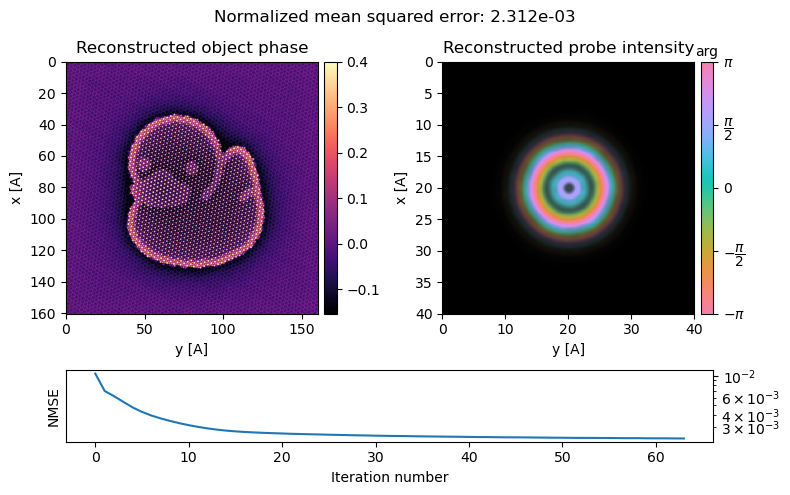

In [3]:
ptycho_01 = py4DSTEM.process.phase.SingleslicePtychography(
    datacube=dataset_01,
    energy=80e3,
    defocus=500,
    vacuum_probe_intensity=probe_01.data,
    device='gpu', # uncomment if you have access to a GPU
    storage='cpu', # uncomment if you have access to a GPU
).preprocess(
    plot_center_of_mass = False,
    plot_rotation=False,
    plot_probe_overlaps=False,
).reconstruct(
    num_iter = 64,
    seed_random=0,
    max_batch_size=512,
).visualize(
)

ptycho_01_object = np.angle(ptycho_01.object_cropped).copy()
ptycho_01_object_fft = ptycho_01.object_fft

First, note that the artifact is only pathological in "blind" ptychgography - i.e. when we have to simultaneously solve for the object and the probe. If we have a good guess for the probe we can use `fix_probe` to eliminate this.

Performing 64 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step_size: 0.5, in batches of max 512 measurements.
Reconstructing object and probe: 100%|██████████| 64/64 [00:12<00:00,  5.17 iter/s]


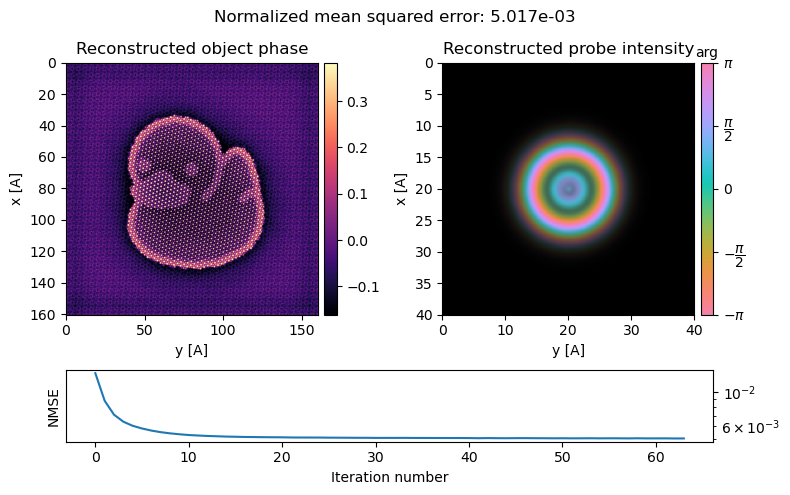

In [4]:
ptycho_01 = ptycho_01.reconstruct(
    reset=True,
    num_iter = 64,
    seed_random=0,
    max_batch_size=512,
    fix_probe=True,
).visualize(
)

ptycho_01_object_fixed = np.angle(ptycho_01.object_cropped).copy()
ptycho_01_object_fft_fixed = ptycho_01.object_fft

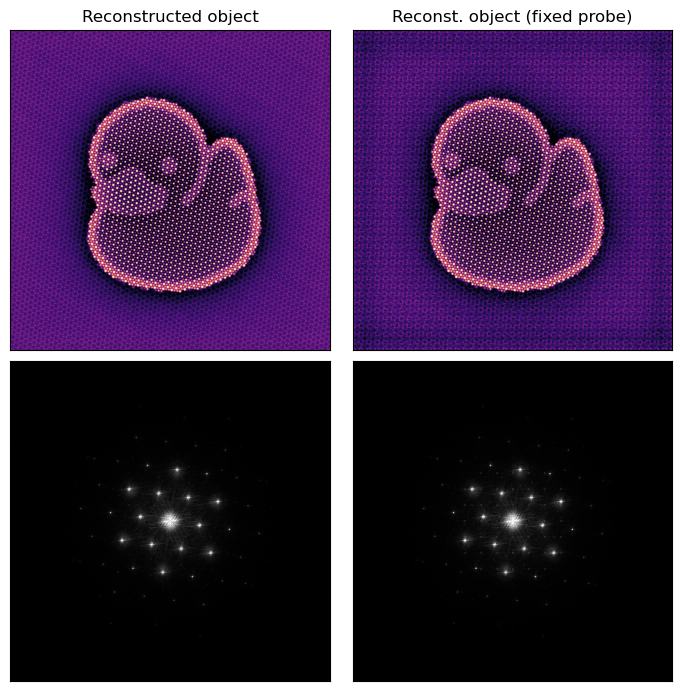

In [5]:
fig, axs = plt.subplots(2,2,figsize=(3.5*2,3.5*2))

py4DSTEM.show(
    [
        ptycho_01_object,
        ptycho_01_object_fixed
    ],
    ticks=False,
    figax=(fig,axs[0]),
    cmap='magma',
    title=[
        "Reconstructed object","Reconst. object (fixed probe)",
    ],
)

py4DSTEM.show(
    [
        ptycho_01_object_fft,
        ptycho_01_object_fft_fixed
    ],
    ticks=False,
    figax=(fig,axs[1]),
    vmin=0.001,
    vmax=0.999,
)

fig.tight_layout()

### Vacuum Probe Measurements

This is why we recommend collecting a vacuum probe measurement before/after the experiment, to constrain the probe and thus remove some of these artifacts.

However, it's important to realize even slight misalignments of the probe aperture with the measured diffraction patterns can result in very aggressive gridding. For example below we initialize with the correct semiangle (20 mrad), but using a different edge "softness".

Best fit rotation = -15 degrees.
Normalizing amplitudes: 100%|██████████| 1681/1681 [00:05<00:00, 327.12probe position/s]
Performing 64 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step_size: 0.5, in batches of max 512 measurements.
Reconstructing object and probe: 100%|██████████| 64/64 [00:11<00:00,  5.41 iter/s]


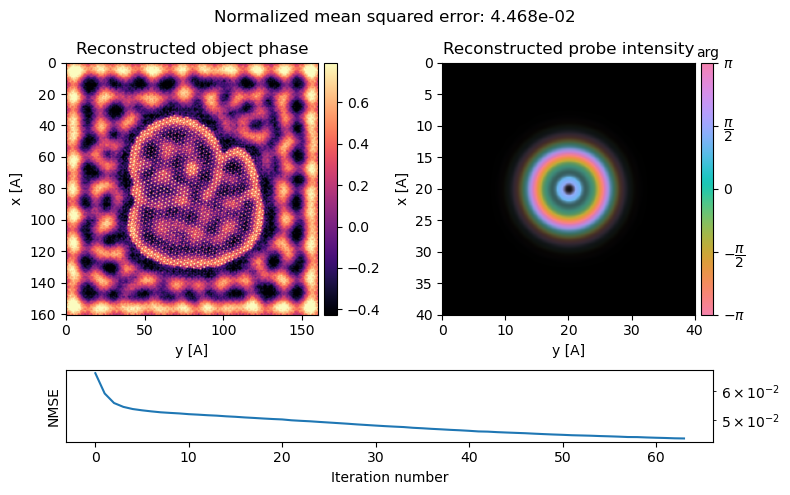

In [29]:
ptycho_01_misaligned = py4DSTEM.process.phase.SingleslicePtychography(
    datacube=dataset_01,
    energy=80e3,
    defocus=500,
    semiangle_cutoff=19, # perfect semicircular aperture
    device='gpu', # uncomment if you have access to a GPU
    storage='cpu', # uncomment if you have access to a GPU
).preprocess(
    plot_center_of_mass = False,
    plot_rotation=False,
    plot_probe_overlaps=False,
).reconstruct(
    num_iter = 64,
    seed_random=0,
    max_batch_size=512,
    fix_probe=True,
).visualize(
)

ptycho_01_misaligned_object = np.angle(ptycho_01_misaligned.object_cropped).copy()
ptycho_01_misaligned_object_fft = ptycho_01_misaligned.object_fft

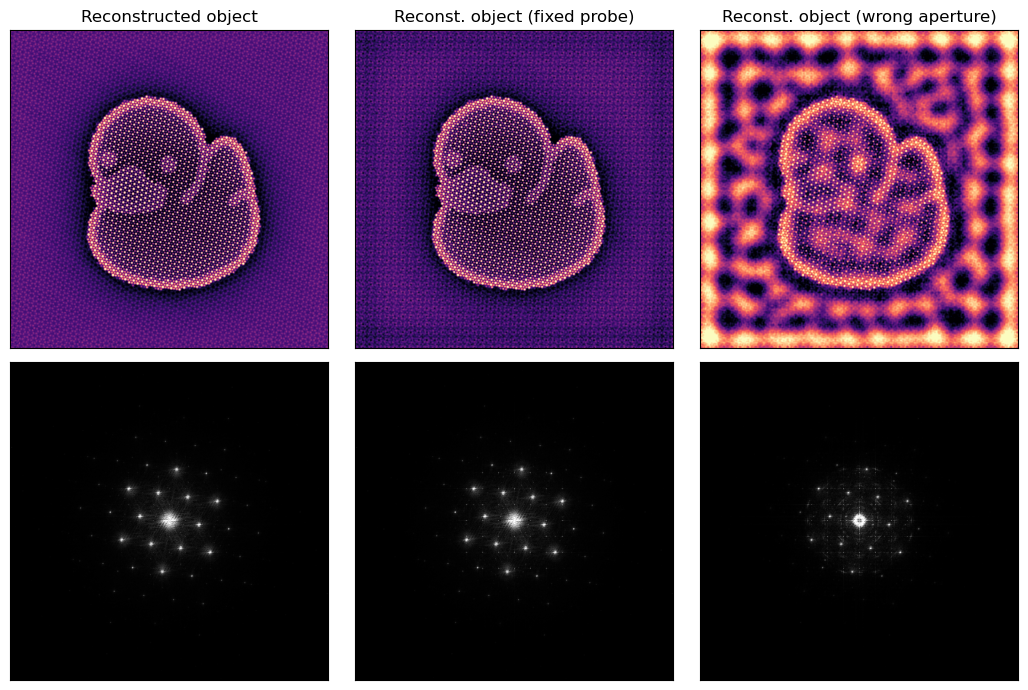

In [30]:
fig, axs = plt.subplots(2,3,figsize=(3.5*3,3.5*2))

py4DSTEM.show(
    [
        ptycho_01_object,
        ptycho_01_object_fixed,
        ptycho_01_misaligned_object,
    ],
    ticks=False,
    figax=(fig,axs[0]),
    cmap='magma',
    title=[
        "Reconstructed object","Reconst. object (fixed probe)",
        "Reconst. object (wrong aperture)"
    ],
)

py4DSTEM.show(
    [
        ptycho_01_object_fft,
        ptycho_01_object_fft_fixed,
        ptycho_01_misaligned_object_fft,
    ],
    ticks=False,
    figax=(fig,axs[1]),
    vmin=0.001,
    vmax=0.999,
)

fig.tight_layout()

### Small Batch Sizes

While it's often useful to initialize the probe with a vacuum probe measurement - we often seek alternative ways of circumventing gridding.  
A simple thing to try is to lower the batch-size and allow the algorithm to recover by more frequent probe update steps:

Performing 64 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step_size: 0.5, in batches of max 8 measurements.
Reconstructing object and probe: 100%|██████████| 64/64 [01:45<00:00,  1.65s/ iter]


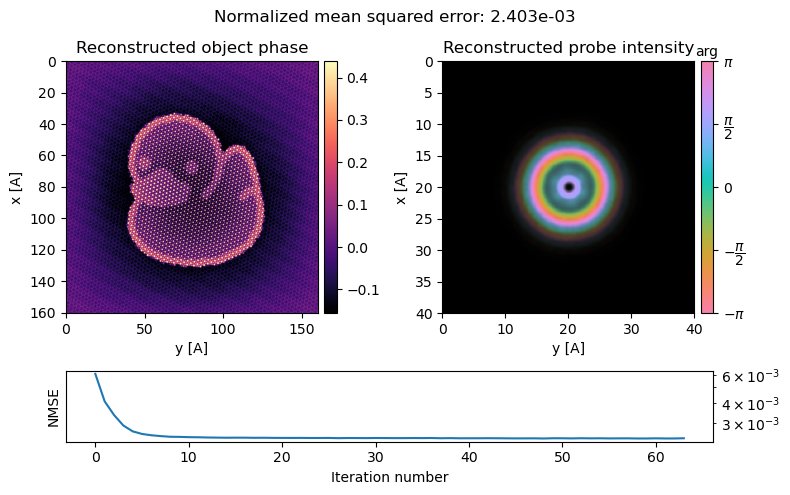

In [8]:
ptycho_01_misaligned = ptycho_01_misaligned.reconstruct(
    reset=True,
    num_iter = 64,
    seed_random=0,
    max_batch_size=8,
).visualize(
)

ptycho_01_misaligned_object_batch = np.angle(ptycho_01_misaligned.object_cropped).copy()
ptycho_01_misaligned_object_fft_batch = ptycho_01_misaligned.object_fft

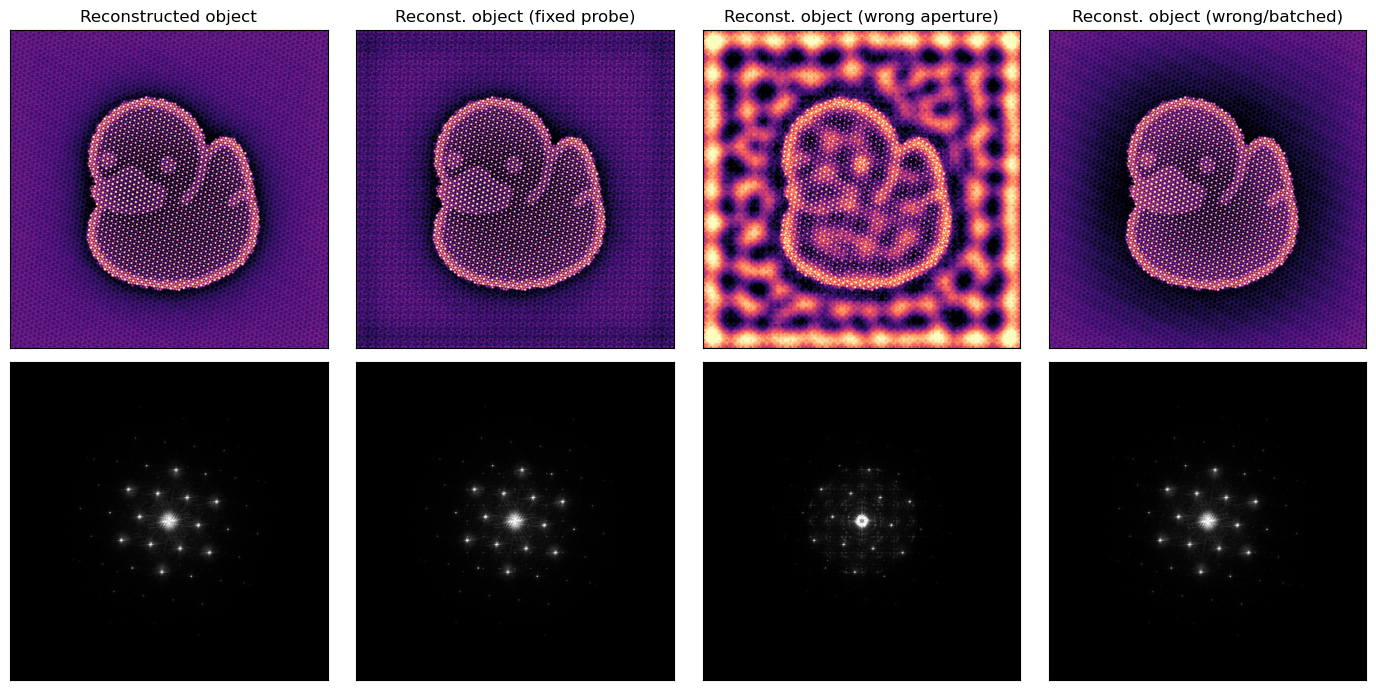

In [31]:
fig, axs = plt.subplots(2,4,figsize=(3.5*4,3.5*2))

py4DSTEM.show(
    [
        ptycho_01_object,
        ptycho_01_object_fixed,
        ptycho_01_misaligned_object,
        ptycho_01_misaligned_object_batch
    ],
    ticks=False,
    figax=(fig,axs[0]),
    cmap='magma',
    title=[
        "Reconstructed object","Reconst. object (fixed probe)",
        "Reconst. object (wrong aperture)","Reconst. object (wrong/batched)",
    ],
)

py4DSTEM.show(
    [
        ptycho_01_object_fft,
        ptycho_01_object_fft_fixed,
        ptycho_01_misaligned_object_fft,
        ptycho_01_misaligned_object_fft_batch
    ],
    ticks=False,
    figax=(fig,axs[1]),
    vmin=0.001,
    vmax=0.999,
)

fig.tight_layout()

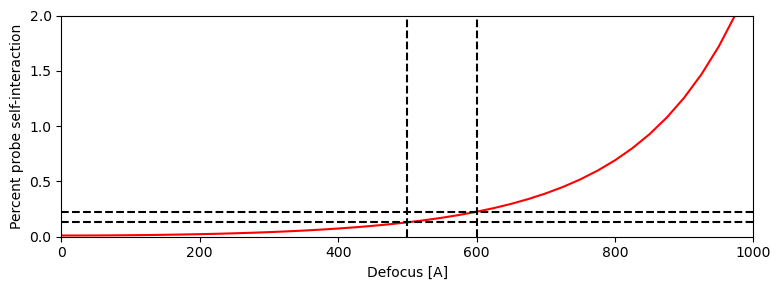

In [14]:
def lost_probe_tails(gpts,**kwargs):

    probe = py4DSTEM.process.phase.utils.ComplexProbe(
        gpts=(gpts[0]*2,gpts[1]*2),
        **kwargs,
    ).build()._array

    probe_intensity = np.abs(np.fft.fftshift(probe))**2
    probe_intensity_inside = 1-np.sum(probe_intensity[gpts[0]//2:-gpts[0]//2,gpts[1]//2:-gpts[1]//2])

    return probe_intensity_inside*100

kwargs = {"energy":80e3,"gpts":(200,200),"sampling":(0.2,0.2),"semiangle_cutoff":20}
defoci = np.arange(0,1000,25)
self_interaction = [lost_probe_tails(defocus=df,**kwargs) for df in defoci]

fig,ax = plt.subplots(figsize=(8,3))
ax.plot(defoci,self_interaction,color='red')
ax.set_xlabel("Defocus [A]")
ax.set_ylabel("Percent probe self-interaction")
ax.vlines([500,600],ymin=0,ymax=2,linestyle="dashed",colors="k")
ax.hlines([self_interaction[20],self_interaction[24]],xmin=0,xmax=1000,linestyle="dashed",colors="k")
ax.set_xlim([0,1000])
ax.set_ylim([0,2])
fig.tight_layout()

In [15]:
print(f"Probe self-interaction:\n    500 A defocus: {self_interaction[20]:.3f}%\n    600 A defocus: {self_interaction[24]:.3f}%")

Probe self-interaction:
    500 A defocus: 0.130%
    600 A defocus: 0.226%


As insignificant as this 0.1% difference in probe self-interaction might seem, it can lead to gridding!

### Mixed-State Ptychography

Finally, we can (ab)use the mixed-state formalism to absorb a lot of the gridding artifacts.  
Note that while we usually try and use a small batch-size to update the probe frequently in mixed-state ptychography, here we deliberately omit the `max_batch_size` option (i.e. use all the probes at once) to absorb the gridding artifact into a "sacrificial" probe.

Best fit rotation = -15 degrees.
Normalizing amplitudes: 100%|██████████| 1681/1681 [00:05<00:00, 325.98probe position/s]
Performing 64 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step_size: 0.5.
Reconstructing object and probe: 100%|██████████| 64/64 [05:07<00:00,  4.80s/ iter]


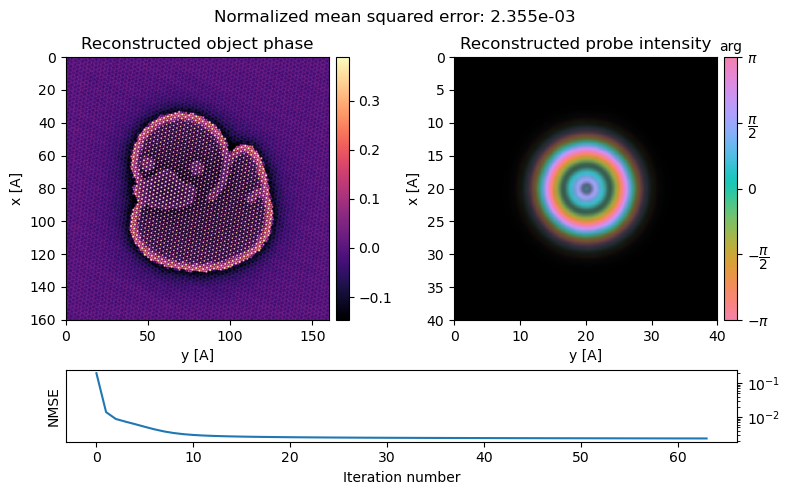

In [19]:
ptycho_01_mixed = py4DSTEM.process.phase.MixedstatePtychography(
    datacube=dataset_01,
    energy=80e3,
    defocus=500,
    vacuum_probe_intensity= probe_01.data,
    num_probes=2,
    device='gpu', # uncomment if you have access to a GPU
    storage='cpu', # uncomment if you have access to a GPU
).preprocess(
    plot_center_of_mass = False,
    plot_rotation=False,
    plot_probe_overlaps=False,
).reconstruct(
    num_iter = 64,
    seed_random=2024,
).visualize(
)

ptycho_01_mixed_object = np.angle(ptycho_01_mixed.object_cropped).copy()
ptycho_01_mixed_object_fft = ptycho_01_mixed.object_fft

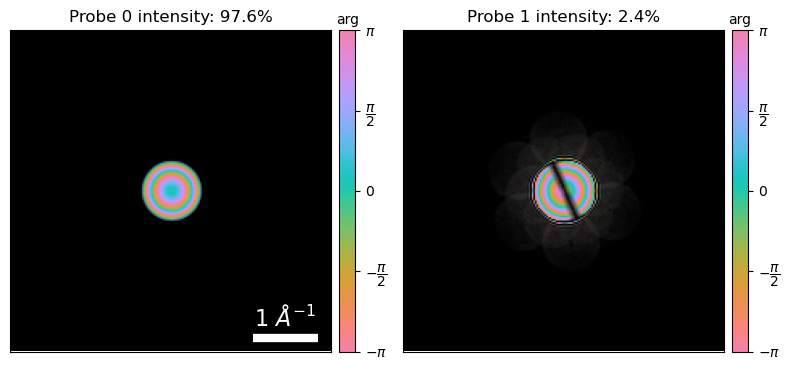

In [20]:
ptycho_01_mixed.show_fourier_probe()

Notice that our first probe "mode" is still doing all the heavy-lifting, with >95% of the intensity. The second probe "mode" is simply used to absorb the measurement noise and gridding artifacts.  
As an added benefit it also absorbs the persky mean-diffraction pattern artifact we saw in the previous tutorial!

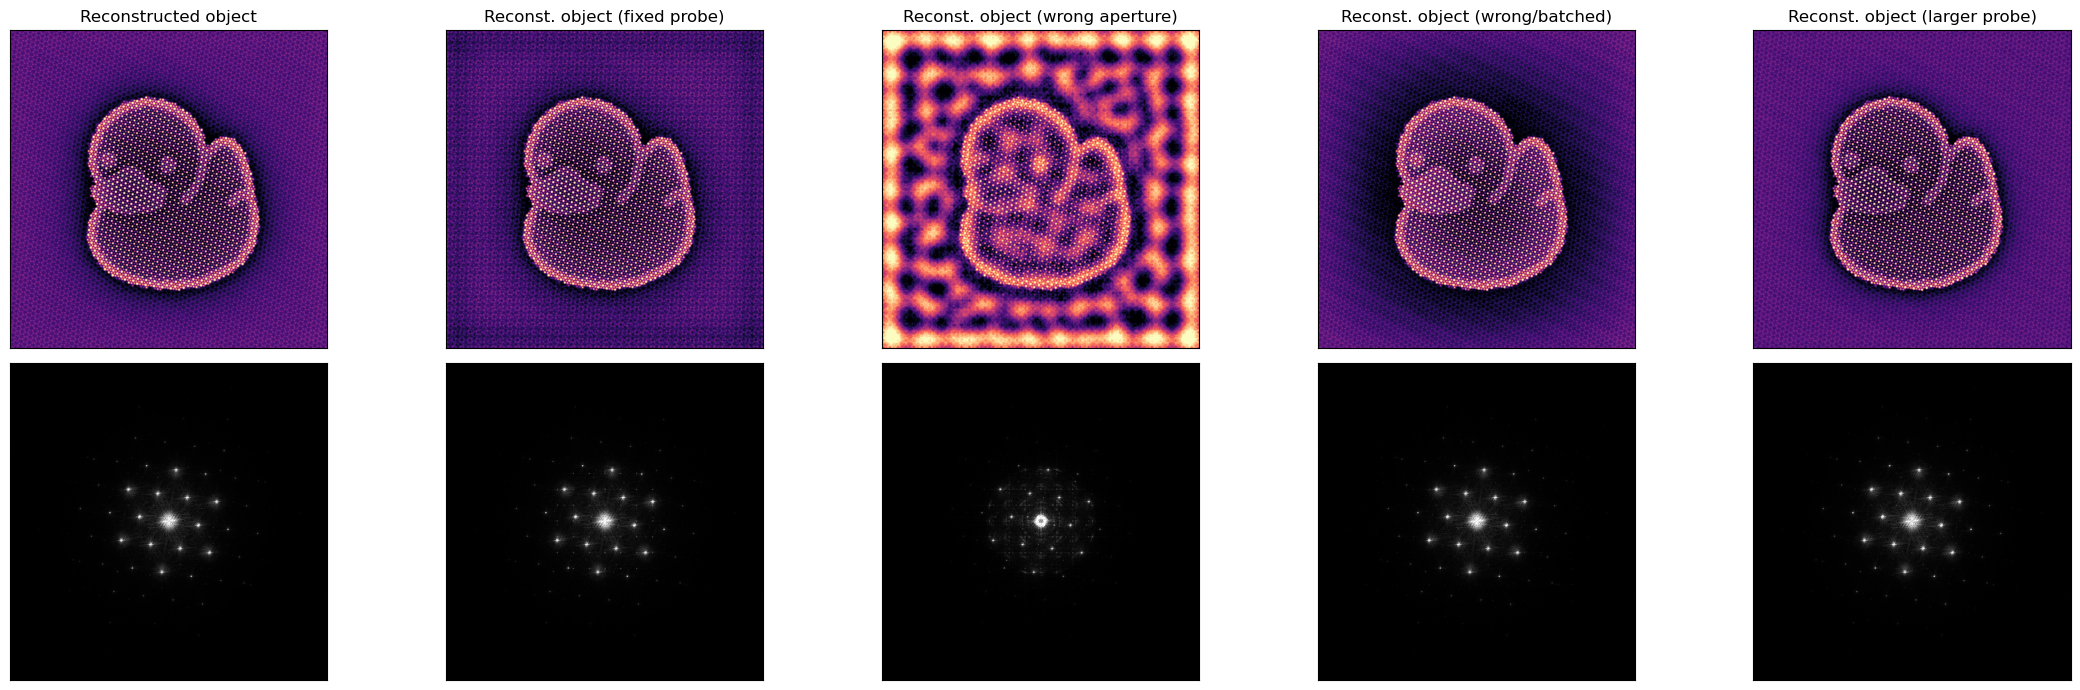

In [32]:
fig, axs = plt.subplots(2,5,figsize=(3.5*7,3.5*2))

py4DSTEM.show(
    [
        ptycho_01_object,
        ptycho_01_object_fixed,
        ptycho_01_misaligned_object,
        ptycho_01_misaligned_object_batch,

        ptycho_01_mixed_object,
    ],
    ticks=False,
    figax=(fig,axs[0]),
    cmap='magma',
    title=[
        "Reconstructed object","Reconst. object (fixed probe)",
        "Reconst. object (wrong aperture)","Reconst. object (wrong/batched)",
        "Reconst. object (larger probe)", "Reconst. object (finer sampling)","Reconst. object (mixed-state)"
    ],
)

py4DSTEM.show(
    [
        ptycho_01_object_fft,
        ptycho_01_object_fft_fixed,
        ptycho_01_misaligned_object_fft,
        ptycho_01_misaligned_object_fft_batch,

        ptycho_01_mixed_object_fft,
    ],
    ticks=False,
    figax=(fig,axs[1]),
    vmin=0.001,
    vmax=0.999,
)

fig.tight_layout()